In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('dataset.csv')
df.shape

(117817, 4)

In [3]:
df.label.value_counts()

economics        9308
tech             9293
business         9258
finance          9167
beauty           9130
entertainment    9028
sports           8876
food             8876
politics         8719
science          8582
travel           8107
environment      7705
world            6211
health           5557
Name: label, dtype: int64

In [4]:
def check_for_noise(df):
    # create a copy
    df = df.copy()
    df = df.fillna(value='', axis=0)
    # create a set for adding all the useless symbols(noise) 
    symbol = set()
    # parse through the data to extract all the unnecessary symbols.
    for col in list(df.columns):
        ### The regular expression states to find all the letters other than words and spaces.
        noise = df[col].str.findall(r'([^\w\s\d]+)')
        for val in noise:
            for sy in val:
                symbol.add(sy)
    # convert back to list.
    symbol = list(symbol)
    return symbol


noises = check_for_noise(df)
print(len(noises))
print(noises[:100])


2386
['+).', '，「', '―', '🎉', ')--', "!!'…", '\x80¦', '🔮', '👏🏼👏🏼', '\u200b\u200b\u200b"', "'+'", ';(', ".'»", '💫"', "'≤,'", '\u2060', '!":', ';}', ')?', '—…', '+."', '$$$$', '🥖', "!',", 'ื่', '🍻', '?!', '™,"', '🇬🇧👸🏻', ']–', '(~', ')+', '✅', '}}","', '\u200b\u200b\u200b\u200b\u200b\u200b.', '🅶🅷🅰🅽🅰', '[?]"', '()', "🔥🤯'", '.👉[', '-;', '="', "')(", "。'<", ':™', ':).', '")(', '",', '🌎', '[©', ".'–", '̨', "?!'", '™.,', '/?', '‘.', '🎥:', '!.', '🔵—', '⌛️', "'™)", '++…', "®.'", '</>', '...............................................................................', 'ุ่', '\x80\x9c', '€™:', '）', 'ٌ', '®(', '***.', '^^', '..................', '🍯', '、「『', "'?><", '，', '@?:@?', ',‡,', '‚±', '[$', '…….', '({\\"', 'ۗ', '(•', '😅)', ';', "'@", '#,', '。（', ")!'", ",'''", '":"\\/\\/', '},', "😭'", '"@', '-°', '✊🏾', ')),']


In [5]:
def preprocess_inputs(df):
    
    # Make a copy of dataset for preprocessing.
    df = df.copy()

    # fill all empty values with blank.
    df = df.fillna(value='', axis=0)

    # remove stopwords from the columns
    f = lambda x: ' '.join([item.lower() for item in x.split(' ') if item.lower() not in stop_words])
    stop_words = set(stopwords.words('english'))
    df['title'] =   df['title'].apply(f)
    df['excerpt'] = df['excerpt'].apply(f)
    df['summary'] = df['summary'].apply(f)

    # clean the data from useless noises
    df['excerpt'] = df['excerpt'].str.replace(r'([^A-Za-z\s]+)', ' ')
    df['summary'] = df['summary'].str.replace(r'([^A-Za-z\s]+)', ' ')
    df['title'] = df['title'].str.replace(r'([^A-Za-z\s]+)', ' ')

    # remove spaces in between
    f = lambda x: ' '.join([item.lower() for item in x.split(' ') if len(item) > 1])
    stop_words = set(stopwords.words('english'))
    df['title'] =   df['title'].apply(f)
    df['excerpt'] = df['excerpt'].apply(f)
    df['summary'] = df['summary'].apply(f)

    
    return df


In [6]:
X = preprocess_inputs(df)

In [7]:
X.head()

,title,excerpt,summary,label
0,new kids block danny wood talks mixtape tour,new kids block danny wood excited bring mixtap...,,entertainment
1,video building police chevy tahoe highway patr...,,,business
2,study shows gun permits soared coronavirus pan...,new study shows number concealed handgun permi...,new study shows number concealed handgun permi...,politics
3,nintendo metroid dread primed breakout success,metroid fans eagerly anticipating new game tak...,reviews stellar new game critic aggregation we...,tech
4,colorblind fish show experts vision evolved bl...,decades studying color vision mice new researc...,decades studying color vision mice new researc...,science


In [8]:
from tqdm import tqdm
from IPython.display import clear_output
import time

for i in tqdm(range(0, 50, 20)):
    arr1 = list(X['title'].iloc[i:i+20])
    arr2 = list(X['label'].iloc[i:i+20])
    for x,y in zip(arr1,arr2):
        print(x," ==== ",y)
    clear_output(wait=True)
    time.sleep(10)


100%|██████████| 3/3 [00:30<00:00, 10.02s/it]


In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report


In [12]:
def get_sequences(texts, tokenizer, train=True, max_seq_length=0):
    sequences = tokenizer.texts_to_sequences(texts)

    if train == True:
        max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

    return sequences


In [13]:
def training(df,mapping):
    df = df.copy()
    # Use only the headline and category columns
    df = df.loc[:, ['title', 'label','excerpt']]
    # Split df into X and y
    df['label'] = df['label'].replace(mapping)
    y = df['label']
    X = df['title'] + ' ' +df['excerpt']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, shuffle=True, random_state=1)

    # Fit a tokenizer
    tokenizer = Tokenizer(num_words=30000)
    tokenizer.fit_on_texts(X_train)

    # Get sequence data
    X_train = get_sequences(X_train, tokenizer, train=True)
    X_test = get_sequences(X_test, tokenizer, train=False,
                           max_seq_length=X_train.shape[1])

    return X_train, X_test, y_train, y_test


mapping = {'economics': 0,
           'tech': 1,
           'business': 2,
           'finance': 3,
           'beauty': 4,
           'entertainment': 5,
           'food': 6,
           'sports': 7,
           'politics': 8,
           'environment': 9,
           'science': 10,
           'travel': 11,
           'world': 12,
           'health': 13
           }


X_train, X_test, y_train, y_test = training(X,mapping)


In [14]:
X_train.shape,y_train.shape

((82471, 107), (82471,))

In [15]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

embedding = tf.keras.layers.Embedding(
    input_dim=30000,
    output_dim=64
)(inputs)

flatten = tf.keras.layers.Flatten()(embedding)

dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)
dense_2 = tf.keras.layers.Dense(128, activation='relu')(dense_1)

outputs = tf.keras.layers.Dense(14, activation='softmax')(dense_2)


model = tf.keras.Model(inputs, outputs)

print(model.summary())
tf.keras.utils.plot_model(model)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 107)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 107, 64)           1920000   
_________________________________________________________________
flatten (Flatten)            (None, 6848)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               876672    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 14)                1806      
Total params: 2,814,990
Trainable params: 2,814,990
Non-trainable params: 0
___________________________________________________

In [16]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/100
2062/2062 [==============================] - 53s 25ms/step - loss: 1.6960 - accuracy: 0.4724 - val_loss: 1.3747 - val_accuracy: 0.5933
Epoch 2/100
2062/2062 [==============================] - 52s 25ms/step - loss: 0.8683 - accuracy: 0.7398 - val_loss: 1.4857 - val_accuracy: 0.5836
Epoch 3/100
2062/2062 [==============================] - 52s 25ms/step - loss: 0.2957 - accuracy: 0.9163 - val_loss: 1.9430 - val_accuracy: 0.5390
Epoch 4/100
2062/2062 [==============================] - 51s 25ms/step - loss: 0.1106 - accuracy: 0.9729 - val_loss: 2.4110 - val_accuracy: 0.5396


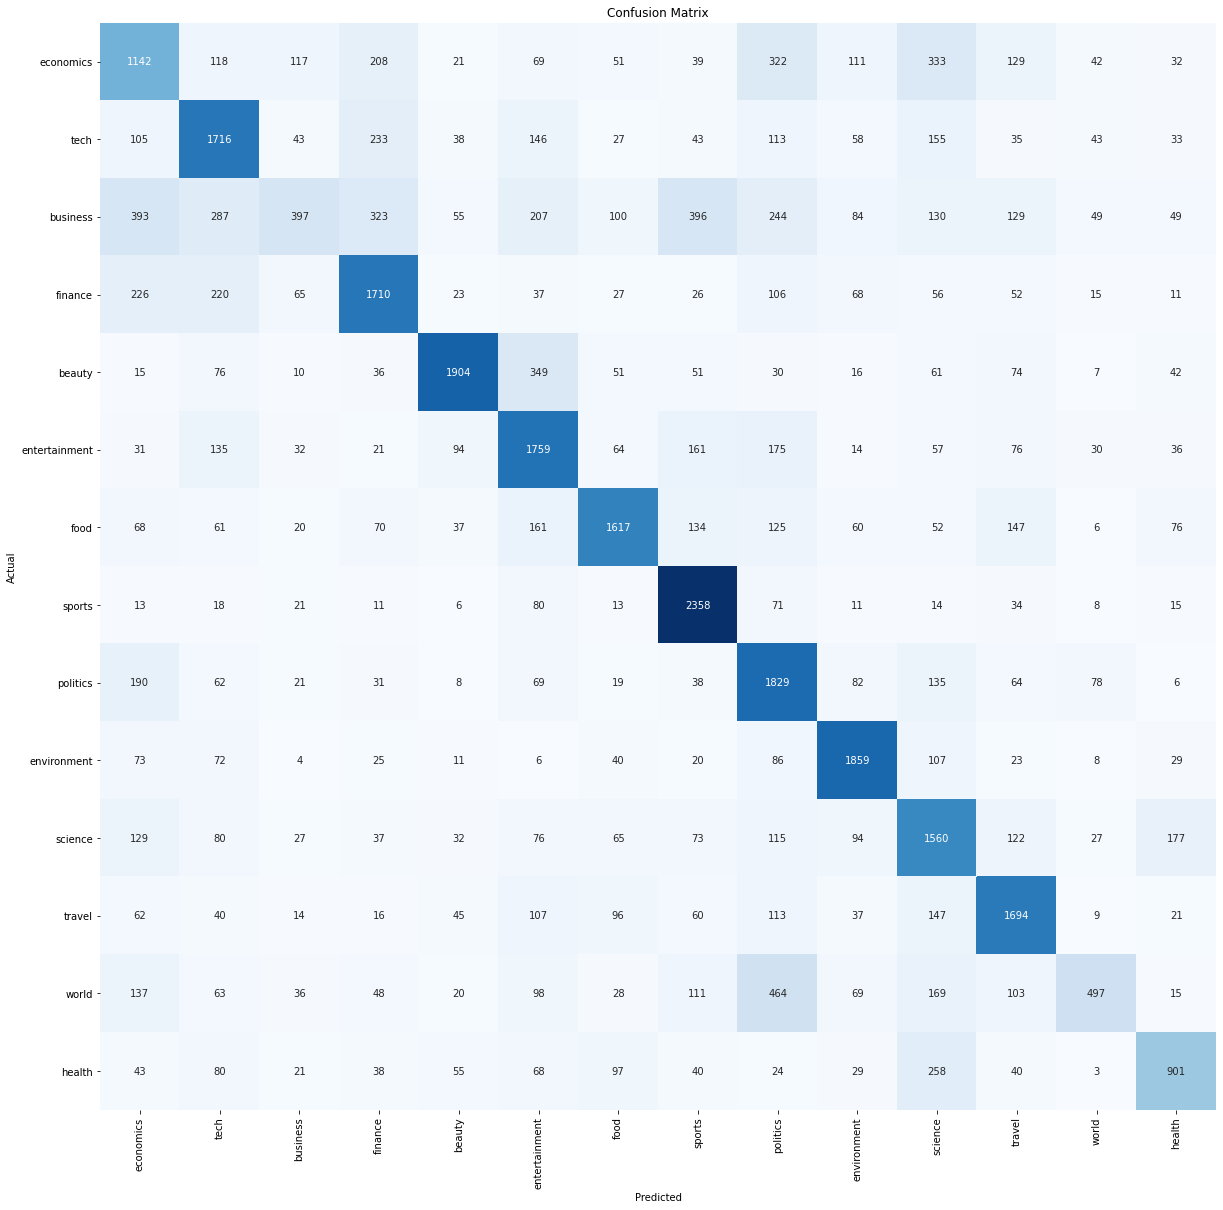

In [17]:
y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(
    y_test, y_pred, target_names=list(mapping.keys()))

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(14) + 0.5,
           labels=list(mapping.keys()), rotation=90)
plt.yticks(ticks=np.arange(14) + 0.5,
           labels=list(mapping.keys()), rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [18]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
                precision    recall  f1-score   support

    economics       0.43      0.42      0.43      2734
         tech       0.57      0.62      0.59      2788
     business       0.48      0.14      0.22      2843
      finance       0.61      0.65      0.63      2642
       beauty       0.81      0.70      0.75      2722
entertainment       0.54      0.66      0.59      2685
         food       0.70      0.61      0.66      2634
       sports       0.66      0.88      0.76      2673
     politics       0.48      0.69      0.57      2632
  environment       0.72      0.79      0.75      2363
      science       0.48      0.60      0.53      2614
       travel       0.62      0.69      0.65      2461
        world       0.60      0.27      0.37      1858
       health       0.62      0.53      0.57      1697

     accuracy                           0.59     35346
    macro avg       0.60      0.59      0.58     35346
 weighted avg   